# ACCESO BIOMÉTRICO CON RECONOCIMIENTO DE VOZ

*Lo que se busca es crear una aplicación de reconocimiento de voz que pueda ser utilizado en las operaciones de negocio, principalmente en la autentificación de clientes*

## Paso 00: Instalación de las librerias necesarias

In [91]:
#!pip install SpeechRecognition
#!pip install PyAudio
#!pip install pipwin
#!pipwin install pyaudio
#!pip install librosa
#!pip install matplotlib
#pip install ffprobe-python
#!pip install ffmpeg-python

## Paso 01: Importamos los paquetes necesarios

In [1]:
##-- Api de google sin token y sin costo, solo audios cortos
import pyaudio as pyaudio
#Cargamos la libreria que transforma el audio a texto
import speech_recognition as sr
#Cargamos la libreria que ejecuta el audio con la finalidad de escucharlo antes de analizar
import IPython.display as ipd 
#Importamos el cliente de google
import io
import os
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types
## llamamos a las librerias
import os
import pandas as pd
import librosa
import glob 
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display
import numpy as np


import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import os
from pydub import AudioSegment

Using TensorFlow backend.
C:\Users\LENOVO\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
np.set_printoptions(suppress=True)

## Paso 02: Captura de voz y partición en microaudios

In [10]:
##------Captura de voz: 
r=sr.Recognizer()

with sr.Microphone() as source:
    print('Menciona tu numero de DNI....')
    audio= r.listen(source)
    print('realizado')

    try:
        voice=r.recognize_google(audio, language='es')
        print(voice)

    except Exception as e:
        print(e)

Menciona tu numero de DNI....
realizado
4485 3351


In [11]:
##-- Validación que el audio y el texto se haya guardado
print(audio)
print(voice)

4485 3351


In [12]:
##--Guardamos el audio en un carpeta.
with open('D:/KONECTA/APLICACIONES/VOICE_RECOGNITION/audio_captura/audio.wav', "wb") as f:
    f.write(audio.get_wav_data())

In [294]:
fileexport='D:/KONECTA/APLICACIONES/VOICE_RECOGNITION/audios_partidos/'
audio=r'D:/KONECTA/APLICACIONES/VOICE_RECOGNITION/audio_captura/audio.wav'

In [295]:
##--Cargamos y probamos el archivo de audio
ipd.Audio(audio, rate=22050) 

In [55]:
###---Partimos el audio en [2] partes y luego guardamos las partes por separado 
voice = AudioSegment.from_wav(audio) 
corte= len(voice)/2
primero = voice[:corte]
segundo=voice[corte:corte*2]
primero.export(r"D:\KONECTA\APLICACIONES\VOICE_RECOGNITION\audios_partidos\audio_primera.wav", format="wav")
segundo.export(r"D:\KONECTA\APLICACIONES\VOICE_RECOGNITION\audios_partidos\audio_segunda.wav", format="wav")

<_io.BufferedRandom name='D:\\KONECTA\\APLICACIONES\\VOICE_RECOGNITION\\audios_partidos\\audio_segunda.wav'>

# Paso 03: preparación de datos

In [3]:
###-Cargamos el archivo de datos de los audios
df=pd.read_excel("D:\KONECTA\APLICACIONES\VOICE_RECOGNITION\ids\dataset.xlsx")
df.head()

,id,genero,persona,test
0,audio60.wav,1,andre,test
1,audio59.wav,1,andre,test
2,audio45.wav,0,pamela,test
3,audio44.wav,0,pamela,test
4,audio30.wav,0,maricruz,test


Class:  maricruz


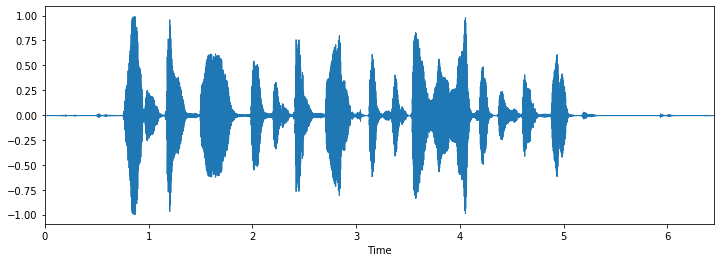

In [4]:
##--Hacemos una prueba tomando un dato aleatorio de la tabla [df] cargadada y con el id jalamos el audio de la carpeta
    ##y lo representamos en un grafico de serie de tiempo de la amplitud de honda.

##--dirección raiz
data_dir=('D://KONECTA//APLICACIONES//VOICE_RECOGNITION')
##--crea una variable con el valor aleatorio de la muestra del tamaño del indice del df
i = random.choice(df.index)
##--toma el ID de la fila seleccionada en el [i]
audio_name = df.id[i]
##--crea la ruta donde se encuentra el audio
path = os.path.join(data_dir, '//audios_enteros', str(audio_name) + '.wav')
##--imprime el nombre de la persona a quien le pertenece el audio
print('Class: ', df.persona[i])
##--carga el archivo en un formato serie de tiempo [x] y almacena el sample rate en [sr]
x, sr = librosa.load(data_dir+'//audios_enteros//'+ str(df.id[i]))
##--imprime la serie de tiempo en un grafico de amplitud de honda
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr)

In [5]:
##--Creamos una funcion para extraer las mediciones del audio.
def extract_features(files): 
    # Establece el nombre de la ruta a donde están los archivos de audio en mi computadora
    file_name = os.path.join(os.path.abspath(data_dir)+'//audios_enteros//'+str(files.id))
    # Carga el archivo de audio como una serie de tiempo de coma flotante y asigna la frecuencia de muestreo predeterminada
    # Sample rate is set to 22050 by default
    # la serie de tiempo esta almacenada en [X]
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    # genera Mel-frequency cepstral coefficients (MFCCs) de la serie de tiempo
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    # Genera una transformada de Fourier a corto plazo (STFT) para usar en chroma_stft
    stft = np.abs(librosa.stft(X))
    # Calcula un cromagrama a partir de una forma de onda o espectrograma de potencia.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    # calcula un espectograma de mel-scaled 
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    # Calcula el contraste espectral
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    # Calcula las características del centroide tonal (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sample_rate).T,axis=0)
    # Agregamos también las clases de cada archivo como una etiqueta al final
    label = files.persona
    # Pedimos que nos devuelva todos los indicadores mas el target
    return mfccs, chroma, mel, contrast, tonnetz,label

In [6]:
##--Obtenemos las caracteristicas de cada audio y medimos el tiempo de demora de la consulta
startTime = datetime.now()
features_label = df.apply(extract_features, axis=1)
print(datetime.now() - startTime)

0:00:26.272287


In [7]:
##--Revisamos los calculos de las caracteristicas del sonido cala fila representa un audio de acuerdo a las filas del df cargado
features_label

0     ([-347.98358, 110.356926, -42.226524, 21.23178...
1     ([-279.2308, 114.64143, -59.00994, 34.292793, ...
2     ([-346.50858, 101.98075, -31.04035, 17.713934,...
3     ([-378.552, 91.83038, -48.545197, 26.3798, -9....
4     ([-305.61966, 71.30409, -32.850853, 33.59814, ...
5     ([-273.65384, 78.837456, -52.025993, 49.948566...
6     ([-402.19592, 83.69835, -15.669347, 29.277094,...
7     ([-369.11026, 76.656876, -44.415874, 23.279488...
8     ([-338.8775, 119.32624, -38.279774, 31.00219, ...
9     ([-380.48224, 78.292984, -42.074978, 25.753841...
10    ([-363.65024, 91.12126, -39.662617, 18.504364,...
11    ([-381.15717, 85.533195, -38.194187, 12.313265...
12    ([-314.1135, 112.4724, -32.01474, 31.708294, 1...
13    ([-293.16028, 114.549, -38.138596, 21.757713, ...
14    ([-345.3767, 100.16017, -28.694717, 24.410856,...
15    ([-294.73553, 132.74684, -46.09224, 18.25612, ...
16    ([-334.76743, 108.87471, -35.743847, 24.677622...
17    ([-275.97528, 124.817566, -48.280197, 30.6

In [8]:
#De la lista generada construimos un array de datos, el cual ingresará a nuestra red neronal
features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

##--El largo del archivo debe ser igual al del df y de los labels
print(len(df))
print(len(features))
labels = df.persona
print(len(labels))

60
60
60


In [9]:
##-.revisamos un array de las personas unicas dentro de labels
np.unique(labels, return_counts=True)

(array(['andre', 'maricruz', 'mariela', 'pamela'], dtype=object),
 array([15, 15, 15, 15], dtype=int64))

In [10]:
##--separamos los valores X y los valores Y
X = np.array(features)
y = np.array(labels)

# recodificamos el valor Y a un tipo categórico
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y),4)

#revisamos los tamaños de los arrays de X e Y: (a:b); a representa total de filas y b total de columnas
print(X.shape)
print(y.shape)

(60, 193)
(60, 4)


In [11]:
##--de acuerdo al df, partimos nuestros arrays en train, validación y test
X_train = X[8:52]
y_train = y[8:52]

X_val = X[52:]
y_val = y[52:]

X_test = X[:8]
y_test = y[:8]

In [12]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(44, 193)
(44, 4)
(8, 193)
(8, 4)
(8, 193)
(8, 4)


In [13]:
#--standarización tradicional
#ss = StandardScaler()
#X_train = ss.fit_transform(X_train)
#X_val = ss.fit_transform(X_val)
#X_test = ss.fit_transform(X_test)

#--normlizacion
X_train =preprocessing.normalize(X_train,norm='l2')
X_val = preprocessing.normalize(X_val,norm='l2')
X_test = preprocessing.normalize(X_test,norm='l2')

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(44, 193)
(8, 193)
(8, 193)


# Paso 04: Modelamiento y validación

In [14]:
##--construimos el modelo CNN
model = Sequential()
model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    
model.add(Dense(4, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [15]:
##--revisamos su notación
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 193)               37442     
_________________________________________________________________
dropout (Dropout)            (None, 193)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 5

In [16]:
##--introducimos en el modelo  los datos de train para que el modelo aprenda, le damos los datos de validación para que 
    ##-- lo pruebe y tomamos un valor de 100 interacciones. todos los calculos de precicion lo guardamos en history.
history = model.fit(X_train, y_train, batch_size=256, epochs=100,validation_data=(X_val, y_val))##,callbacks=[early_stop])

Epoch 1/100
1/1 [==============================] - 0s 158ms/step - loss: 1.3992 - accuracy: 0.1364 - val_loss: 1.3791 - val_accuracy: 0.2500
Epoch 2/100
1/1 [==============================] - 0s 29ms/step - loss: 1.3768 - accuracy: 0.3182 - val_loss: 1.3752 - val_accuracy: 0.2500
Epoch 3/100
1/1 [==============================] - 0s 27ms/step - loss: 1.3781 - accuracy: 0.2273 - val_loss: 1.3713 - val_accuracy: 0.3750
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: 1.3916 - accuracy: 0.2045 - val_loss: 1.3677 - val_accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 1.3680 - accuracy: 0.3409 - val_loss: 1.3645 - val_accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 1.3777 - accuracy: 0.2955 - val_loss: 1.3615 - val_accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 1.3718 - accuracy: 0.4318 - val_loss: 1.3584 - val_accuracy: 0.5000
Epoch 8/100
1/1 [==

1/1 [==============================] - 0s 29ms/step - loss: 0.5886 - accuracy: 0.8182 - val_loss: 0.4366 - val_accuracy: 0.7500
Epoch 59/100
1/1 [==============================] - 0s 29ms/step - loss: 0.5838 - accuracy: 0.7273 - val_loss: 0.4237 - val_accuracy: 0.7500
Epoch 60/100
1/1 [==============================] - 0s 32ms/step - loss: 0.5237 - accuracy: 0.7955 - val_loss: 0.4138 - val_accuracy: 1.0000
Epoch 61/100
1/1 [==============================] - 0s 27ms/step - loss: 0.5051 - accuracy: 0.8182 - val_loss: 0.4054 - val_accuracy: 1.0000
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.88 - 0s 28ms/step - loss: 0.4907 - accuracy: 0.8864 - val_loss: 0.3988 - val_accuracy: 1.0000
Epoch 63/100
1/1 [==============================] - 0s 27ms/step - loss: 0.5091 - accuracy: 0.7500 - val_loss: 0.3896 - val_accuracy: 1.0000
Epoch 64/100
1/1 [==============================] - 0s 25ms/step - loss: 0.5270 - accuracy: 0.7727 - val_loss: 0.3786 - val_a

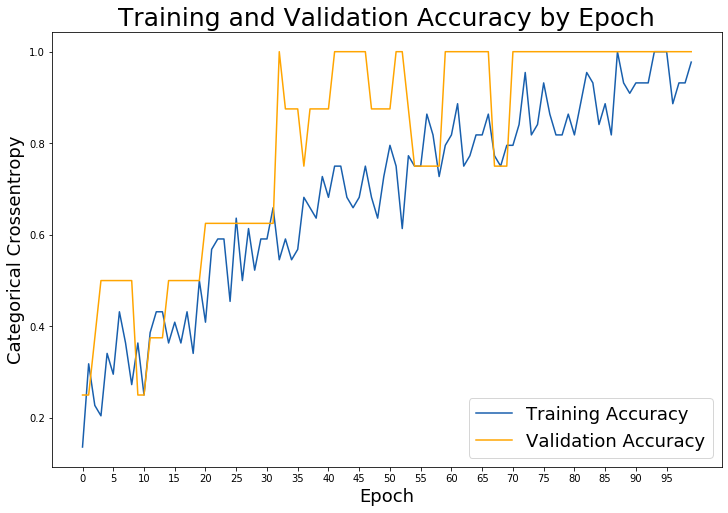

In [17]:
# Consulte la precisión de nuestro tren y la precisión de validación durante épocas.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Establecer el tamaño de la figura.
plt.figure(figsize=(12, 8))

# Genere un diagrama lineal de entrenamiento, probando la pérdida en épocas.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Establecer título
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

# Paso 05: Prueba de test

In [18]:
# Obtenemos nuestras predicciones de los datos de prueba
preds = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [19]:
# # Transformamos nuestras predicciones a los ID..
preds = lb.inverse_transform(preds)

In [20]:
# Cortamos nuestro marco de datos a nuestro marco de datos de prueba
df_test = df[:8]

In [21]:
#Creamos una nueva columna llamada preds
df_test['preds'] = preds

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
##--comparamos los resultados de persona vs la preds.
df_test

,id,genero,persona,test,preds
0,audio60.wav,1,andre,test,andre
1,audio59.wav,1,andre,test,andre
2,audio45.wav,0,pamela,test,pamela
3,audio44.wav,0,pamela,test,pamela
4,audio30.wav,0,maricruz,test,maricruz
5,audio29.wav,0,maricruz,test,maricruz
6,audio15.wav,0,mariela,test,pamela
7,audio14.wav,0,mariela,test,mariela


# Paso 06: Predicción de audio nuevo.

In [24]:
##------Captura de voz:
#Cargamos la libreria que transforma el audio a texto
import speech_recognition as sr
r=sr.Recognizer()

with sr.Microphone() as source:
    print('Menciona tu numero de DNI....')
    nuevo= r.listen(source)
    print('realizado')

    try:
        voice=r.recognize_google(nuevo, language='es')
        print(voice)

    except Exception as e:
        print(e)

Menciona tu numero de DNI....
realizado
Hoy estamos 23 del 6 del 2020


In [25]:
with open('D:/KONECTA/APLICACIONES/VOICE_RECOGNITION/audios_enteros/nuevo.wav', "wb") as f:
    f.write(nuevo.get_wav_data())

In [26]:
audio=r'D:/KONECTA/APLICACIONES/VOICE_RECOGNITION/audios_enteros/nuevo.wav'

In [27]:
##--Cargamos y probamos el archivo de audio
ipd.Audio(audio, rate=22050) 

In [28]:
data= pd.DataFrame(columns=('id', 'genero', 'persona', 'test'))
data.loc[len(data)]=['nuevo.wav',0,'nuevo','nuevo'] 

In [29]:
nuevo = data.apply(extract_features, axis=1)

In [30]:
features_new = []
for i in range(0, len(nuevo)):
    features_new.append(np.concatenate((nuevo[i][0], nuevo[i][1], 
                nuevo[i][2], nuevo[i][3],
                nuevo[i][4]), axis=0))

In [31]:
##--separamos los valores X y los valores Y
Xnuevo = np.array(features_new)

In [32]:
X_Xnuevo=preprocessing.normalize(Xnuevo,norm='l2')

In [33]:
# We get our predictions from the test data
preds = model.predict_classes(X_Xnuevo)
# # Transformamos nuestras predicciones a los ID..
preds = lb.inverse_transform(preds)
preds

array(['andre'], dtype=object)